In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


100%|██████████| 10000/10000 [04:57<00:00, 33.65it/s]


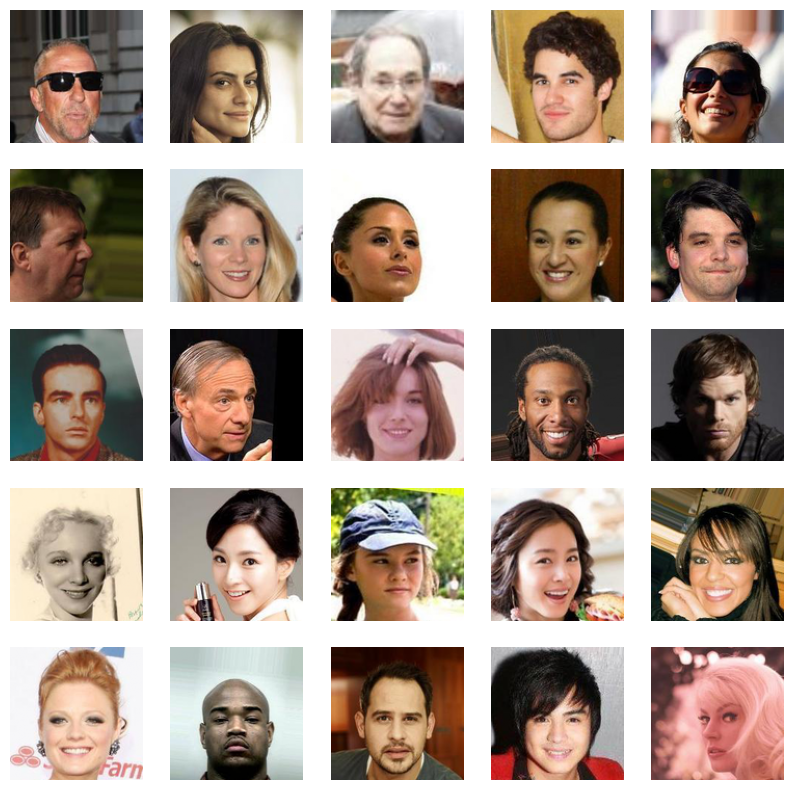

In [3]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
PIC_DIR = '/content/drive/MyDrive/datasets/celeba/celeba-dataset/img_align_celeba/img_align_celeba/'
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))#Normalize the images
images = np.array(images) / 255
images.shape#print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
import zipfile
LATENT_DIM = 32
CHANNELS = 3
# class Generator(nn.Module):
#     def __init__(self, latent_dim, img_shape):
#         super(Generator, self).__init__()
#         self.img_shape = img_shape
#         self.model = nn.Sequential(
#             nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.Tanh()
#         )
    
#     def forward(self, z):
#         img = self.model(z)
#         return img
# class Discriminator(nn.Module):
#     def __init__(self, img_shape):
#         super(Discriminator, self).__init__()
#         self.img_shape = img_shape
#         self.model = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
#             nn.Sigmoid()
#         )
    
#     def forward(self, img):
#         validity = self.model(img)
#         validity = validity.view(-1, 1)
#         return validity


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
latent_dim = 100
img_shape = (1, 28, 28)

generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)


In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer_G = optim.RMSprop(generator.parameters(), lr=0.0001, alpha=0.9)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.0001, alpha=0.9)


In [7]:
import time
import numpy as np
from PIL import Image
import os

iters = 20000
batch_size = 16
RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'

if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = torch.randn(CONTROL_SIZE_SQRT**2, latent_dim) / 2

images_saved = 0

step = 0
d_losses = []
g_losses = []

for epoch in range(iters):
    start_time = time.time()
    for real_images, _ in dataloader:
        batch_size = real_images.size(0)
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1)
        fake = torch.zeros(batch_size, 1)
        optimizer_D.zero_grad()
        # Generate a batch of fake images
        z = torch.randn(batch_size, latent_dim)
        gen_images = generator(z)
        # Loss for real and fake images
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(gen_images.detach()), fake)
        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        # Update discriminator
        d_loss.backward()
        optimizer_D.step()
        optimizer_G.zero_grad()
        # Generator loss: the generator tries to make the discriminator classify its output as real
        g_loss = criterion(discriminator(gen_images), valid)
        # Update generator
        g_loss.backward()
        optimizer_G.step()
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if step % 50 == 49:
            print(f'{step+1}/{iters}: d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}. ({time.time() - start_time:.1f} sec)')

            control_image = np.zeros((28 * CONTROL_SIZE_SQRT, 28 * CONTROL_SIZE_SQRT))

            with torch.no_grad():
                control_generated = generator(control_vectors).cpu().numpy()

            for i in range(CONTROL_SIZE_SQRT ** 2):
                x_off = i % CONTROL_SIZE_SQRT
                y_off = i // CONTROL_SIZE_SQRT
                control_image[x_off * 28:(x_off + 1) * 28, y_off * 28:(y_off + 1) * 28] = control_generated[i, 0, :, :] * 0.5 + 0.5

            im = Image.fromarray(np.uint8(control_image * 255), mode="L")
            im.save(FILE_PATH % (RES_DIR, images_saved))
            images_saved += 1

        step += 1
        if step >= iters:
            break 


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
15200/20000: d_loss: 0.6882,  a_loss: 0.8345.  (0.5 sec)
1/1 [==============================] - 0s 21ms/step
15250/20000: d_loss: 0.6700,  a_loss: 0.9197.  (0.5 sec)
1/1 [==============================] - 0s 20ms/step
15300/20000: d_loss: 0.6773,  a_loss: 0.7915.  (0.5 sec)
1/1 [==============================] - 0s 22ms/step
15350/20000: d_loss: 0.6868,  a_loss: 0.8771.  (0.5 sec)
1/1 [==============================] - 0s 21ms/step
15400/20000: d_loss: 0.5860,  a_loss: 0.9033.  (0.5 sec)
1/1 [==============================] - 0s 21ms/step
15450/20000: d_loss: 0.6819,  a_loss: 1.0364.  (0.5 sec)
1/1 [==============================] - 0s 22ms/step
15500/20000: d_loss: 0.6992,  a_loss: 0.7893.  (0.5 sec)
1/1 [==============================] - 0s 20ms/step
15550/20000: d_loss: 0.7213,  a_loss: 0.8906.  (0.5 sec)
1/1 [==============================] - 0s 20ms/step
15600/20000: d_loss: 0.65

In [11]:
test_image_path = "/content/res2/generated_399.png"
test_image = Image.open(test_image_path).crop(crop_rect)
test_image.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
test_image = np.expand_dims(np.uint8(test_image), axis=0) / 255


In [12]:
latent_vector = np.random.normal(size=(1, LATENT_DIM))
generated_image = generator.predict(latent_vector)


1/1 [==============================] - 0s 22ms/step


In [13]:
combined_images_test = np.concatenate([generated_image, test_image])
labels_test = np.concatenate([np.ones((1, 1)), np.zeros((1, 1))])
labels_test += .05 * np.random.random(labels_test.shape)

test_loss = discriminator.evaluate(combined_images_test, labels_test, verbose=0)
print("Test loss: {:.4f}".format(test_loss))



Test loss: 0.5791
